In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

#read test and train datasets
mercedes_train = pd.read_csv('dataset/train.csv')
mercedes_test = pd.read_csv('dataset/test.csv')
print(mercedes_train.shape)
print(mercedes_test.shape)

(4209, 378)
(4209, 377)


   ID       y  X0 X1  X2 X3 X4 X5 X6 X8  ...  X375  X376  X377  X378  X379  \
0   0  130.81   k  v  at  a  d  u  j  o  ...     0     0     1     0     0   
1   6   88.53   k  t  av  e  d  y  l  o  ...     1     0     0     0     0   
2   7   76.26  az  w   n  c  d  x  j  x  ...     0     0     0     0     0   
3   9   80.62  az  t   n  f  d  x  l  e  ...     0     0     0     0     0   
4  13   78.02  az  v   n  f  d  h  d  n  ...     0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 378 columns]
    feature data type
0        ID     int64
1         y   float64
2        X0    object
3        X1    object
4        X2    object
..      ...       ...
373    X380     int64
374    X382     int64
375    X383     int64
376    X384     int64
377    X385     int64

[378 rows x 2 columns]


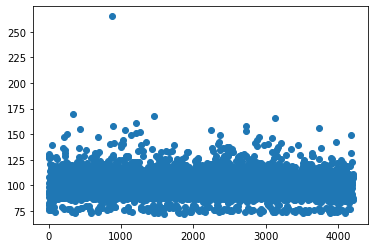

265.32 883
169.91 342


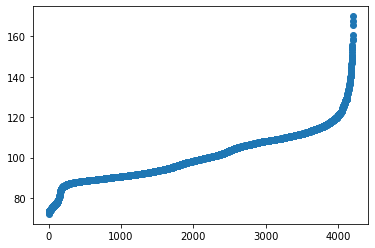

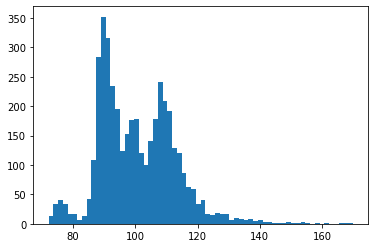

In [2]:
mercedes_train.columns
print(mercedes_train.head())
mercedes_train_dtype_info = mercedes_train.dtypes.reset_index()
mercedes_train_dtype_info.columns = ['feature', 'data type']
print(mercedes_train_dtype_info)
mercedes_train_dtype_info.groupby('data type').aggregate('count').reset_index()
y = mercedes_train.y
plt.figure()
plt.scatter(range(mercedes_train.shape[0]), mercedes_train.y.values)
plt.show()
print(mercedes_train.y.max(), mercedes_train.y.idxmax())
mercedes_train.drop(index=883, inplace=True)
print(mercedes_train.y.max(), mercedes_train.y.idxmax())
plt.figure()
plt.scatter(range(mercedes_train.shape[0]), np.sort(mercedes_train.y.values))
plt.show()
no_of_bins = int(math.sqrt(mercedes_train.shape[0]))
plt.figure()
plt.hist(mercedes_train.y.values, bins=no_of_bins)
plt.show()

In [4]:
#Data Pre Processing
#Check for missing values in both test and train datasets
missing_columns_test = mercedes_test[[col for col in mercedes_test.columns if mercedes_test[col].isnull().any()==True]].isna().sum()
print(missing_columns_test.values)

missing_columns_train = mercedes_train[[col for col in mercedes_train.columns if mercedes_train[col].isnull().any()==True]].isna().sum()
print(missing_columns_train.values)

#remove features with zero variance as they are unlikely to influence final solution positively
from sklearn.feature_selection import VarianceThreshold

thresh = VarianceThreshold(threshold = 0.001)

removed_var_train = thresh.fit_transform(mercedes_train)
removed_var_test = thresh.fit_transform(mercedes_test)

filtered_train = mercedes_train[mercedes_train.columns[thresh.get_support(indices = True)]]
filtered_test = mercedes_test[mercedes_test.columns[thresh.get_support(indices = True)]]

[]
[]


ValueError: could not convert string to float: 'k'

We find that there are no missing values in either dataset.

In [17]:
print(filtered_train.shape)
print(filtered_test.shape)

(4208, 327)
(4209, 327)


So from 377 and 378 columns in test and train datasets respectively, we have 327 columns each remaining. Therefore, columns with zero variances have been dropped.

In [18]:
#remove highly correlated features
correlation_matrix_train = filtered_train.corr()
correlation_matrix_test = filtered_test.corr()
threshold = 0.95
np.fill_diagonal(correlation_matrix_train.values, -2)
np.fill_diagonal(correlation_matrix_test.values, -2)


In [19]:
filtered_train.drop(columns = correlation_matrix_train.columns[(correlation_matrix_train >= threshold).any()], inplace = True)
filtered_test.drop(columns = correlation_matrix_test.columns[(correlation_matrix_test >= threshold).any()], inplace = True)
#(correlation_matrix >= 0.85).any()

/home/brainwave/miniconda3/envs/directml/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
filtered_test.shape


(4209, 222)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

x_train, x_test, y_train, y_test = train_test_split(filtered_train.drop(columns = ['y']), filtered_train.y, random_state = 0)


In [44]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

x_train_standardized = standard_scaler.fit_transform(x_train)
x_test_standardized = standard_scaler.fit_transform(x_test)
x_final_standardized = standard_scaler.fit_transform(filtered_test)


In [27]:

x_train_standardized.shape

(3156, 231)

In [29]:
#feature engineering
from sklearn.decomposition import PCA
PCAModel = PCA(210)
x_train_component = PCAModel.fit_transform(x_train_standardized)
x_test_component = PCAModel.fit_transform(x_test_standardized)
x_final_compoenent = PCAModel.fit_transform(x_final_standardized)

PCAModel.explained_variance_
PCAModel.explained_variance_ratio_*100

np.cumsum(PCAModel.explained_variance_ratio_*100)

array([  6.59799706,  12.17128489,  16.36515442,  19.8608163 ,
        22.87398175,  25.69713348,  27.8959935 ,  29.87508731,
        31.75193077,  33.57323831,  35.3208608 ,  37.02511157,
        38.60359089,  39.974364  ,  41.27301474,  42.5513898 ,
        43.75858066,  44.93142108,  46.06436651,  47.16385852,
        48.25674582,  49.30220748,  50.32976695,  51.33299933,
        52.258508  ,  53.15855591,  54.02427416,  54.8883764 ,
        55.73020492,  56.55660877,  57.36019685,  58.12714054,
        58.87234116,  59.60405065,  60.31750726,  61.02610302,
        61.71189596,  62.37773802,  63.01995403,  63.6593369 ,
        64.29509667,  64.91523168,  65.51667954,  66.10296045,
        66.68097281,  67.25150438,  67.80856822,  68.35716901,
        68.90105462,  69.4372892 ,  69.96609483,  70.4870089 ,
        71.00118061,  71.51391315,  72.02042258,  72.52539452,
        73.02059685,  73.51284255,  73.99932831,  74.48358479,
        74.96568755,  75.44483857,  75.91799749,  76.38

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
rfr=RandomForestRegressor( max_depth=7, min_samples_leaf=3,n_estimators=100,
                       min_samples_split=2)
rfr.fit(x_train,y_train)
y_predictrfr = rfr.predict(x_train)

In [31]:
#here we can check our model score
print(rfr.score(x_train,y_train))
print(rfr.score(x_test,y_test))
print('RMSE:' + str(np.sqrt(mean_squared_error(y_test,rfr.predict(x_test)))))

0.6550786760455394
0.5747313792478843
RMSE:7.78335073152843


In [32]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(x_train_component,y_train)
print('LR train model:' + str( model.score(x_train_component,y_train)))
print('LR test model:' + str(model.score(x_test_component,y_test)))

LR train model:0.6218901703903486
LR test model:-0.11672419964138636


In [36]:
from xgboost import XGBRegressor
XGB=XGBRegressor()
XGB.fit(x_train_standardized,y_train)

print('XGB train model:' + str( XGB.score(x_train_standardized,y_train)))
print('XGB test  model:' + str(XGB.score(x_test_standardized,y_test)))

XGB train model:0.9170956228887092
XGB test  model:0.4728581929196717


In [40]:
from sklearn.linear_model import Lasso

lassoModel=Lasso(alpha=.0001)
lassoModel.fit(x_train_component,y_train)
print("Train Score (Linear):",lassoModel.score(x_train_component,y_train))
print("Test Score (Linear):",lassoModel.score(x_test_component,y_test))


Train Score (Linear): 0.6216935171895437
Test Score (Linear): -0.11660841157483537


In [41]:
from sklearn.linear_model import ElasticNet

EModel=ElasticNet(alpha=.0001)
EModel.fit(x_train_component,y_train)
print("Train Score (Linear):",EModel.score(x_train_component,y_train))
print("Test Score (Linear):",EModel.score(x_test_component,y_test))


Train Score (Linear): 0.6216820877778301
Test Score (Linear): -0.11661894686554541


In [45]:
#prediction of the test_data
rfr.predict(x_final_compoenent)

/home/brainwave/miniconda3/envs/directml/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


ValueError: X has 210 features, but RandomForestRegressor is expecting 231 features as input.